## What makes a successful movie?

## Data Collection
We scraped the IMDb website for movie metadata. We started from the advance search result page so we would only get results from a specific time range and valid number of ratings. 
The raw metadata looks like this: 
![alt webpage](https://i.imgur.com/CdMKpSx.png)



In order to obtain the data, we used 2 libraries. First we get the webpages in HTML using requests. Secondly we used beautiful soup to parse the HTML and retrieved the features. For the features, we decided to encode genre as 1s and 0s using one-hot encoding which will facilitate our further investigation.


In [19]:
import requests, re
import pandas as pd
import numpy as np
from time import sleep
from bs4 import BeautifulSoup
GENRES = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 
'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 
'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

the function that parses a single HTML page

In [20]:
def parse_page(html, df):
    def parse_votes(resultSet):
        try:
            nvs = resultSet[0].find_all("span", {"name" :"nv"})
            if (len(nvs) == 1):
                return (int(nvs[0].text.replace(",", "")), np.nan)
            return (int(nvs[0].text.replace(",", "")), nvs[1].text)
        except: 
            return (0,0)
    
    soup = BeautifulSoup(html, 'html.parser')
    # make a list of movies
    listerlist = soup.find_all('div', class_ = "lister-item mode-advanced")
    
    # get all the titles
    imgList = [movieItem.find('img') for movieItem in listerlist]
    nameList = [imgItem["alt"] for imgItem in imgList]
    
    # get all the ratings
    ratingsRaw = [movieItem.find("strong") for movieItem in listerlist]
    ratings = [float(rawRating.text) for rawRating in ratingsRaw]

    # get the number of votes. Due to the weird HTML structure, the gross and vote are listed together so it needs to be parsed
    voteNumRaw = [movieItem.find_all("p", class_="sort-num_votes-visible") for movieItem in listerlist]
    votes = [parse_votes(raw) for raw in voteNumRaw]

    # get the year of release
    yearsRaw = [movieItem.find("span", class_ = "lister-item-year text-muted unbold") for movieItem in listerlist]
    years = [int(re.findall("\d{4}", rawYear.text)[0]) for rawYear in yearsRaw]

    # get the list of genres of a film
    genresRaw = [movieItem.find("span", class_ = "genre") for movieItem in listerlist]
    genres = [(list(map(lambda x: x.strip(), rawGenre.text.split(","))) if (rawGenre !=None) else []) for rawGenre in genresRaw]
    
    # get the summaries. Sometimes there is some exception due to the ill-formatted HTML
    try:
        summaryRaw = [movieItem.find_all("p", class_="text-muted") for movieItem in listerlist]
        summaries = [raw[1].text.strip() for raw in summaryRaw]
    except:
        summaries = [""] * len(nameList)

    # insert a film as a column to the overall data frame
    for i in range(len(nameList)):  
        info = dict()
        info["Name"] = nameList[i]
        info["Rating"] = ratings[i]
        info["Year"] =  years[i]
        info["Votes"] = votes[i][0]
        info["Gross"] = votes[i][1]
        info["Summary"] = summaries[i]

        for GENRE in GENRES:
            info["Genre_" + GENRE] = (int(GENRE in genres[i]))
        df = df.append(info, ignore_index=True)
    
    # retrieve the link to the next 250 movies
    nextRaw = soup.select("a.lister-page-next.next-page")
    nextURL = nextRaw[0]["href"] if (len(nextRaw) > 0) else None
    if (nextURL != None):
        nextURL = "http://www.imdb.com/search/title"+nextURL
    return(df, nextURL)

below is an example of a processed webpage.

In [21]:
d = pd.DataFrame(columns=['Name', "Rating", "Year", "Votes", "Gross", "Summary",
                            "Genre_Action", "Genre_Adventure", "Genre_Animation",
                            "Genre_Biography", "Genre_Comedy", "Genre_Crime", 
                            "Genre_Documentary", "Genre_Drama", "Genre_Family",
                            "Genre_Fantasy", "Genre_Film-Noir", "Genre_Game-Show",
                            "Genre_History", "Genre_Horror", "Genre_Music",
                            "Genre_Musical", "Genre_Mystery", "Genre_News", 
                            "Genre_Reality-TV", "Genre_Romance", "Genre_Sci-Fi",
                            "Genre_Sport", "Genre_Talk-Show", "Genre_Thriller",
                            "Genre_War", "Genre_Western"])
# demo & debug
html = requests.get("https://www.imdb.com/search/title?title_type=feature&release_date=2014-01-01,&num_votes=1,&countries=us&count=250&sort=release_date,asc").text
(df, link) = (parse_page(html, d))
print(link)
df.head()

http://www.imdb.com/search/title?title_type=feature&release_date=2014-01-01,&num_votes=1,&countries=us&count=250&sort=release_date,asc&page=2&ref_=adv_nxt


,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Mystery,Genre_News,Genre_Reality-TV,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Talk-Show,Genre_Thriller,Genre_War,Genre_Western
0,Paranormal Activity: The Marked Ones,5.0,2014,35349,$32.46M,When a young man becomes the target of a malev...,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Layla Live or Die,5.8,2014,17,NaN,A Middle Eastern girl comes to America to for ...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Percentage,6.1,2014,1937,NaN,"In Miami, two hustlers on the run set up a cre...",1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Grace of God,5.7,2014,20,NaN,"Having lost his faith many years ago, Detectiv...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Let's Ruin It with Babies,5.5,2014,212,NaN,"Channing has it all- a beautiful house, a rock...",0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Then we chained the processing together using a wrapper that retrieves all the movies.
During this process, we observed that there is a weird behavior of IMDb. It only gives us 10,000 films after a query from advanced search. So we separated our calls into 3 to get the data.

In [22]:
# the function that get the html text all related to one link.
def parseAllAfter1950(url, fileName):
    df = pd.DataFrame(columns=['Name', "Rating", "Year", "Votes", "Gross", "Summary",
                            "Genre_Action", "Genre_Adventure", "Genre_Animation",
                            "Genre_Biography", "Genre_Comedy", "Genre_Crime", 
                            "Genre_Documentary", "Genre_Drama", "Genre_Family",
                            "Genre_Fantasy", "Genre_Film-Noir", "Genre_Game-Show",
                            "Genre_History", "Genre_Horror", "Genre_Music",
                            "Genre_Musical", "Genre_Mystery", "Genre_News", 
                            "Genre_Reality-TV", "Genre_Romance", "Genre_Sci-Fi",
                            "Genre_Sport", "Genre_Talk-Show", "Genre_Thriller",
                            "Genre_War", "Genre_Western"])
    while(url):
        html = requests.get(url).text
        try:
            (df, url) = parse_page(html, df)
        except:
            print(url)
        sleep(0.2)
    # save to a pickle for future use
    df.to_pickle(fileName)
    
# link = "http://www.imdb.com/search/title?title_type=feature&release_date=1950-01-01,&num_votes=1,&countries=us&sort=release_date,asc"
# link2 = "http://www.imdb.com/search/title?title_type=feature&release_date=1985-10-04,&num_votes=1,&countries=us&sort=release_date,asc"
# link3 = "http://www.imdb.com/search/title?title_type=feature&release_date=2001-01-01,&num_votes=1,&countries=us&count=250&sort=release_date,asc"

After scraping, we concatenated the dataframes together to get a complete data set.

In [23]:
df1 = pd.read_pickle("mov-1.pkl")
df2 = pd.read_pickle("mov-2.pkl")
df3 = pd.read_pickle("mov-3.pkl")
movie_df = pd.concat([df1,df2, df3]).drop_duplicates().reset_index(drop=True)
movie_df = movie_df[movie_df[movie_df.columns[6:]].sum(axis = 1) != 0]
movie_df = movie_df[movie_df['Year'] <= 2010]
movie_df.head()

,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Mystery,Genre_News,Genre_Reality-TV,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Talk-Show,Genre_Thriller,Genre_War,Genre_Western
0,The Flying Saucer,3.8,1950,301,NaN,Both the CIA and KGB investigate UFOs in Alask...,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,The File on Thelma Jordon,7.0,1950,1523,NaN,Assistant district attorney Cleve Marshall fal...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Traveling Saleswoman,6.3,1950,25,NaN,"In this western comedy, the King Soap Company ...",1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Davy Crockett, Indian Scout",5.5,1950,191,NaN,"Davy Crockett (not the famous Alamo hero, but ...",0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Cry Murder,5.8,1950,6,NaN,A young actress has retired from films to marr...,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Then we observed that some genres only have very few movie instances. This is problematic for our future processing so we removed those genres.

In [24]:
#remove genres
generes = movie_df.columns[6:]
genre_count = movie_df.iloc[:,6:].sum()
genres_to_remove= movie_df.iloc[:,6:].columns[(genre_count < 200)]
try:
    movie_df = movie_df.drop(genres_to_remove, axis = 1)
except:
    pass

The last step we did to the data frame is to process the gross column (which was text in the format "$1.5M" into numbers that can be used.

In [25]:
def parse_gross(s):    
    try:
        if (s[-1]=="M"):
            return (float(s[1:-1]))
    except:
        return np.nan    
movie_df["Gross"] = movie_df["Gross"].apply(parse_gross)

By now, we have gotten a movie_df data frame that contains all the information we may use to analyze.

In [26]:
movie_df.head()

,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War,Genre_Western
0,The Flying Saucer,3.8,1950,301,NaN,Both the CIA and KGB investigate UFOs in Alask...,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,The File on Thelma Jordon,7.0,1950,1523,NaN,Assistant district attorney Cleve Marshall fal...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Traveling Saleswoman,6.3,1950,25,NaN,"In this western comedy, the King Soap Company ...",1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,"Davy Crockett, Indian Scout",5.5,1950,191,NaN,"Davy Crockett (not the famous Alamo hero, but ...",0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Cry Murder,5.8,1950,6,NaN,A young actress has retired from films to marr...,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [27]:
# imports
import matplotlib.pyplot as plt
import matplotlib
from collections import deque

## Popularity calculation

In [28]:
def get_values(df):
    v = []
    R = []
    for genre in df.columns[6:-1]:
        v1 = sum(df[df[genre] == 1]['Votes'])
        r1 = np.mean(df[df[genre] == 1]['Rating'])
        R.append(r1)
        v.append(v1)
    m = np.mean(df['Votes'])
    C = np.mean(df['Rating'])
    return np.asarray(R), np.asarray(v), m, C
def true_bayesian_estimate(df):
    R, v, m, C = get_values(df)
    return (v/(v+m))*R + (m/(v+m))*C
def true_bayesian_estimate_1(df):
    R = df["Rating"]
    v = df["Votes"]
    m = v.quantile([.25, .5, .75])[0.25]
    C = (R).mean()
    return (v/(v+m))*R + (m/(v+m))*C

In [29]:
ps = true_bayesian_estimate_1(movie_df)
ps = np.nan_to_num(ps)
movie_df = movie_df.assign(Popularity = pd.Series(ps).values.astype("float"))


In [30]:
# split the data into years
dfs = []
years = list(range(1950, 2000, 10))
for start in range(1950, 2010, 10):
    dfs.append(movie_df[np.logical_and(movie_df['Year'] >= start, movie_df['Year'] < (start + 10))])
movie_df[10000:]

,Name,Rating,Year,Votes,Gross,Summary,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,...,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War,Genre_Western,Popularity
10264,The American Way,5.8,1986,401,NaN,A group of Vietnam vets disturbs television pr...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.800068
10265,Top Gun,6.9,1986,245084,179.80,As students at the United States Navy's elite ...,1,0,0,0,...,0,0,0,1,0,0,0,0,0,6.899789
10266,Nightmare Weekend,2.9,1986,456,NaN,A female scientist performs experiments on thr...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3.171035
10267,Max mon amour,6.1,1986,772,NaN,A married French woman takes a zoo chimp named...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.082821
10268,Playing for Keeps,4.0,1986,543,2.67,"Danny, Spikes and Silk have just recently grad...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.143441
10269,Monster in the Closet,4.9,1986,2031,NaN,After several people and a dog are found dead ...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4.920371
10270,Shadow Play,5.4,1986,71,NaN,A playwright who's staying with the mother of ...,0,0,0,0,...,0,0,1,0,0,0,0,0,0,5.559580
10271,The Last of Philip Banter,5.2,1986,35,NaN,An alcoholic partier becomes a paranoid maniac...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.544274
10272,Down by Law,7.8,1986,40942,1.44,Two innocent people are arrested. An interesti...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.797707
10273,Class of Nuke 'Em High,5.7,1986,6751,NaN,The pupils at a high school next to a nuclear ...,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.700696


### is the rating normal distributed?

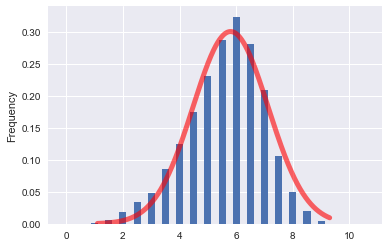

In [31]:
from scipy.stats import norm

r = movie_df['Rating']
r.plot(kind='hist',histtype = 'bar', align = "left",rwidth = 0.5,bins=[i*0.5 for i in range(23)], normed = True)
x = np.linspace(r.min(), r.max(), r.shape[0])
rv = norm(loc = np.mean(r), scale = np.std(r))
plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()


From the dirstribution of the ratings. We found the ratings centered around 6

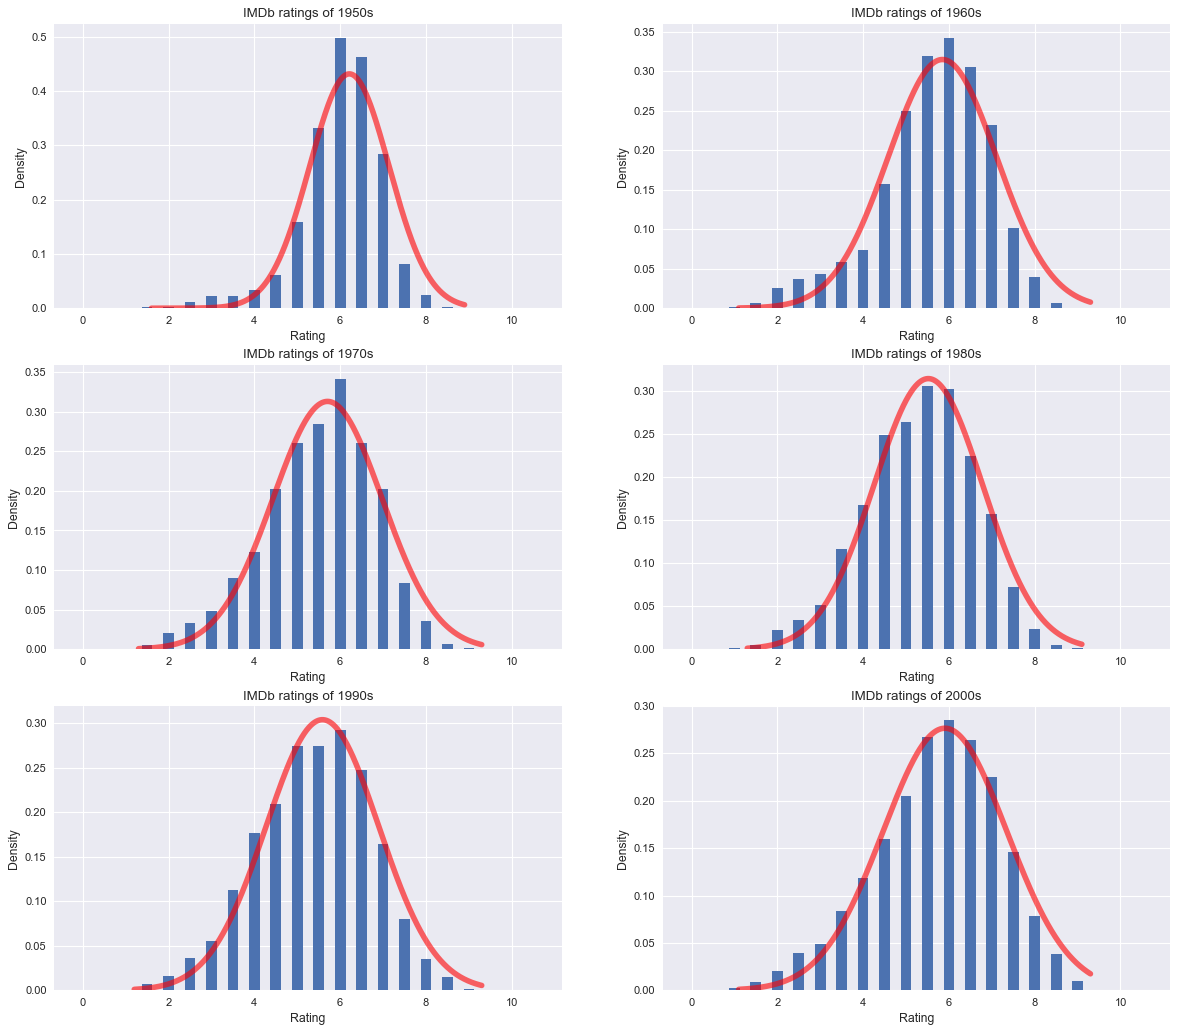

In [32]:
%matplotlib inline
i = 0
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for col in dfs:
    ax = plt.subplot2grid((3,2), (i//2, i%2))
    i = i + 1
    r = col['Rating']
    ax.hist(r, histtype = 'bar', align = "left",rwidth = 0.5,bins=[i*0.5 for i in range(23)], normed=True)
    plt.xlabel("Rating")
    plt.ylabel("Density")
    plt.title("IMDb ratings of "+ str(1940+i*10)+"s")
    x = np.linspace(r.min(), r.max(), r.shape[0])

    rv = norm(loc = np.mean(r), scale = np.std(r))
    ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()


The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate:
weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
Where:
 - R = average rating for across movie = (Rating)
 - v = number of votes for across movie = (votes)
 - m = a good number of votes to rely on the rating based on votes (m as the average number of votes)
 - C = the mean ratings of all movies

## How popularity varies across genres

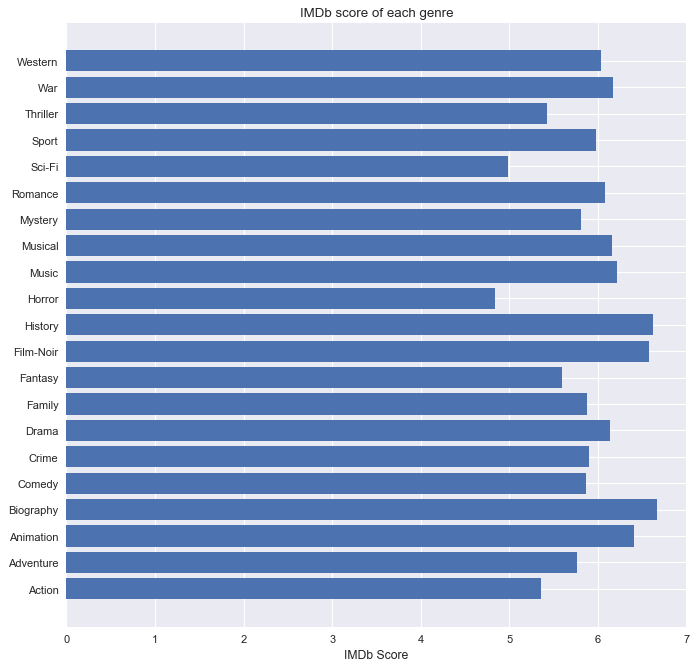

In [33]:
y = true_bayesian_estimate(movie_df)
font = {'family' : 'Arial',
        'size'   : 12}
matplotlib.rc('font', **font)
labels = list(movie_df.columns[6:-1])
labels = [x.replace('Genre_','') for x in labels]
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
y = np.nan_to_num(y)
plt.barh(labels, y)
plt.xlabel('IMDb Score')
plt.title("IMDb score of each genre")
plt.show()
plt.savefig('scorevsgenre.png')

In [34]:
indx = (-y).argsort()[:4]
top_genres = [labels[i] for i in indx ]
top_genres

['Biography', 'History', 'Film-Noir', 'Animation']

In [35]:
import scipy.stats as st

for i in range(len(top_genres)):
    a = movie_df[movie_df[''.join(['Genre_' ,top_genres[i]])] == 1]["Popularity"]
    b = movie_df[movie_df[''.join(['Genre_' ,top_genres[i]])] == 0]["Popularity"]
    ## Cross Checking with the internal scipy function
    t2, p2 = st.ttest_ind(a,b)
#     print("t = " + str(t2))
    print(top_genres[i] + " p-value: " + str(p2))
#     print("p = " + str(p2))

Biography p-value: 1.211337525941477e-100
History p-value: 9.992623594019654e-55
Film-Noir p-value: 4.301388884286685e-46
Animation p-value: 4.358555890585483e-33


Hypothesis testing From the hypothesis testing, for each genre in the top genres, it has the popularity larger than the other genres.

TODO: Reformat and explanation

# EDITED
Since we have those assumptions we validated above, it is possible to get a clearer idea of top genres over the decades. We plotted a heatmap to view the average ratings of a genre in all decades.
The horizontal axis is the movie genre, the vertical axis is the decades and lighter cells indicate higher average scores.

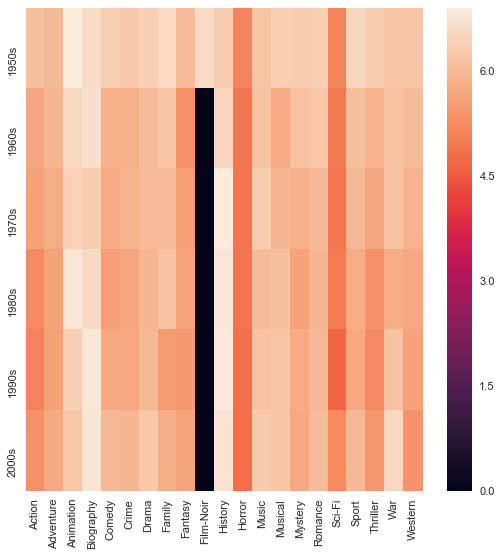

In [36]:
import seaborn as sns; sns.set()
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')

all_years = pd.DataFrame(columns = [ col.split("_")[1] for col in movie_df.columns[6:-1]])
for i in range(6):
    df = dfs[i]
    y = true_bayesian_estimate(df)
    y = np.nan_to_num(y)
    all_years.loc[i] = y
all_years.index = [str(start)+"s"  for start in range(1950, 2010, 10)]
ax = sns.heatmap(all_years)

From the plot we can observe that one of the column 

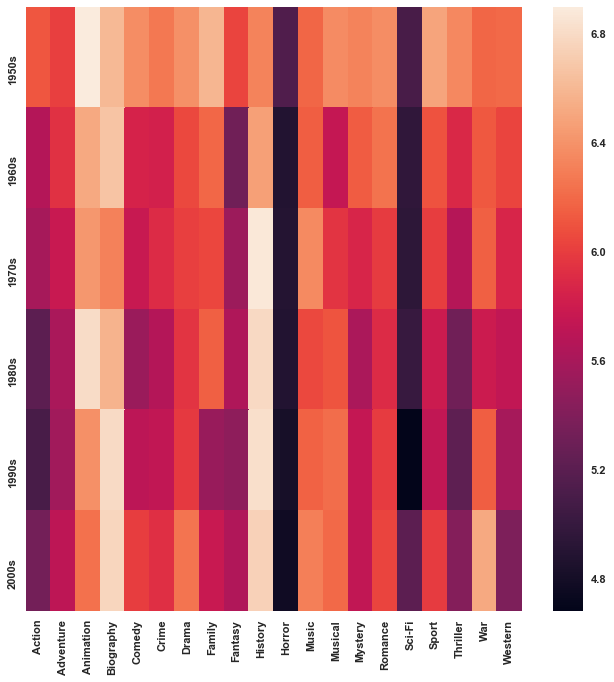

In [44]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

all_years_without_fn = all_years.drop(["Film-Noir"], axis = 1)
ax = sns.heatmap(all_years_without_fn)

In [18]:
# film - noir

## How year affects the market (ratings,  gross, popularity)
Time Series

## The average gross over years
To find the trend of the gross over years, apply the sliding average on this time series data to smooth out short-term flucatuations and find the longer-term trend.

In [47]:

class SlidingAverage:
    def __init__(self,k):
        """ Initializes a sliding average calculator which keeps track of the average of the last k seen elements. 
        
        Args: 
            k (int): the number of elements to average (the half-width of the sliding average window)
        """
        self.k = k
        self.s = deque(maxlen = 2*k + 1)
        self.s.extend([None] * k)
        self.sum = 0.0
        self.num = 0.0
        
    def update(self,x):
        """ Computes the sliding average after having seen element x 
        
        Args:
            x (float): the next element in the stream to view
            
        Returns: 
            (float): the new sliding average after having seen element x, if it can be calculated
        """
        self.s.append(x)
        if x is not None:
            self.sum = self.sum + x
            self.num = self.num + 1
        if len(self.s) == 2*(self.k) + 1:
            slidingavg = self.sum/(self.num)
            if (not (self.s[0] is None)):
                self.num = self.num - 1
                self.sum = self.sum - self.s[0]

            return slidingavg
        return None
    

def compute_sliding_averages(s, k):
    """ Computes the sliding averages for a given Pandas series using the SlidingAverage class. 
    
    Args:
        s (pd.Series): a Pandas series for which the sliding average needs to be calculated
        k (int): the half-width of the sliding average window 
        
    Returns:
        (pd.Series): a Pandas series of the sliding averages
    
    """
    if k == 0:
        return s
    sa = SlidingAverage(k)
    s1 = pd.Series()
    snew = [val for val in map(sa.update, s) if val is not None]  
    snew.extend([val for val in map(sa.update, [None]*k) if val is not None])
    s1 = s1.append(pd.Series(snew))
    return s1

In [48]:
subdf = movie_df.dropna()


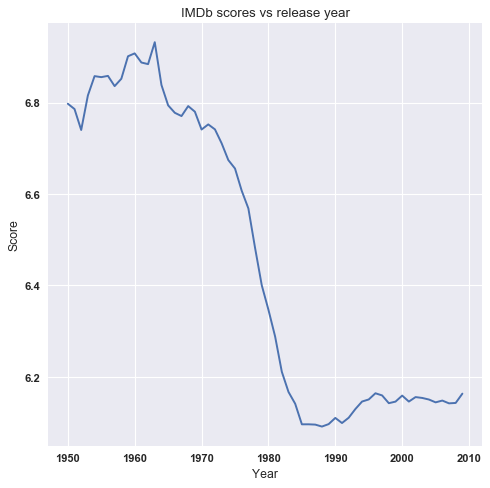

In [56]:
fig=plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')

pop_y = subdf.groupby(['Year'])['Popularity'].mean()
pop_y_slide_average = compute_sliding_averages(pd.Series(pop_y),5)
plt.plot(range(1950, 2010), pop_y_slide_average)
plt.xlabel("Year")
plt.ylabel("Score")
plt.title("IMDb scores vs release year")

plt.show()

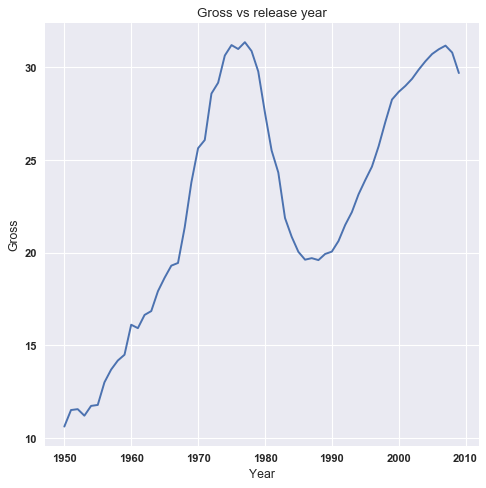

In [57]:

fig=plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
gross_y = subdf.groupby(['Year'])['Gross'].mean()
gross_y_slide_average = compute_sliding_averages(pd.Series(gross_y),5)
plt.plot(range(1950, 2010), gross_y_slide_average)
plt.xlabel("Year")
plt.ylabel("Gross")
plt.title("Gross vs release year")
plt.show()

#### df.columns

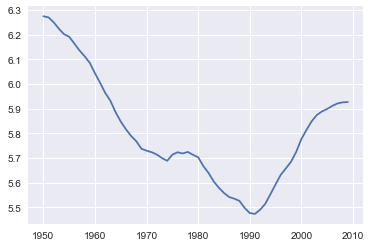

In [23]:
rating_y1 = movie_df.groupby(['Year'])['Rating'].mean()
rating_y1_slide_average = compute_sliding_averages(pd.Series(rating_y1),5)
plt.plot(range(1950, 2010), rating_y1_slide_average)
plt.show()

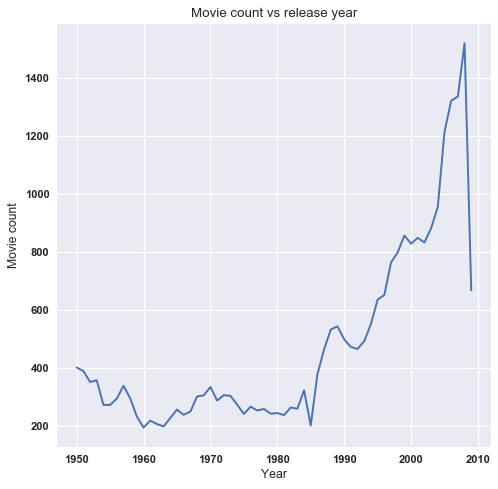

In [58]:
fig=plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
rating_y1 = movie_df.groupby(['Year'])['Name'].count()
plt.plot(range(1950, 2010),rating_y1)
plt.xlabel("Year")
plt.ylabel("Movie count")
plt.title("Movie count vs release year")
plt.show()

## Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression

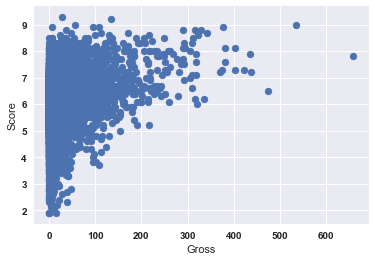

In [59]:
#ax= sns.regplot(x=subdf["Popularity"], y = subdf["Gross"],lowess=True)
plt.scatter(movie_df["Gross"].values.reshape(-1, 1), movie_df["Popularity"])
plt.xlabel("Gross")
plt.ylabel("Score")
plt.show()

In [61]:
from regressors import stats
from sklearn.linear_model import LinearRegression
lm = LinearRegression(fit_intercept=True, normalize=False)  
subdf = movie_df.dropna()
X = np.asarray(subdf["Gross"]).reshape(-1,1)
y = np.asarray(subdf["Popularity"])
lm.fit(X, y)
print(lm.coef_)
print(stats.coef_pval(lm, X, y))
stats.summary(lm, X, y)

[0.00559987]
[0. 0.]
Residuals:
Min      1Q  Median      3Q     Max
-3.0953 -0.6628 -0.0754  0.5736  4.2231


Coefficients:
            Estimate  Std. Error   t value  p value
_intercept  6.045928    0.013389  451.5471      0.0
x1          0.005600    0.000227   24.6274      0.0
---
R-squared:  0.06209,    Adjusted R-squared:  0.06196
F-statistic: 465.39 on 1 features


In [62]:
lm = LinearRegression(fit_intercept=True, normalize=False)  
generes = subdf.columns[5:]

subdf["Year"] = subdf["Year"] - 1940
X1 = np.asarray(subdf.iloc[:,[2]+list(range(6,subdf.shape[1] - 2))+ [4]], dtype='float')
y1 = np.asarray(subdf["Popularity"], dtype='float')
lm.fit(X1, y1)

coefs = lm.coef_
pvals = stats.coef_pval(lm, X1, y1)
stats.summary(lm, X1, y1)

Residuals:
Min      1Q  Median      3Q     Max
-2.6031 -0.5914 -0.0613  0.5019  4.2098


Coefficients:
            Estimate  Std. Error   t value   p value
_intercept  6.598568    0.058050  113.6696  0.000000
x1         -0.012754    0.000228  -55.8297  0.000000
x2         -0.385830    0.031314  -12.3215  0.000000
x3         -0.038970    0.035078   -1.1109  0.266634
x4          0.402649    0.064654    6.2277  0.000000
x5          0.422220    0.054536    7.7420  0.000000
x6         -0.199091    0.024628   -8.0838  0.000000
x7          0.084367    0.028824    2.9270  0.003433
x8          0.494219    0.024634   20.0622  0.000000
x9         -0.345096    0.043672   -7.9020  0.000000
x10        -0.069373    0.043854   -1.5819  0.113714
x11         0.645667    0.295408    2.1857  0.028872
x12         0.203504    0.072979    2.7885  0.005309
x13        -0.341172    0.041103   -8.3004  0.000000
x14        -0.100950    0.057582   -1.7531  0.079620
x15         0.046109    0.078018    0.5910  0.554

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [82]:
variable_names = [subdf.columns[2]]+ list(subdf.columns[6:subdf.shape[1] - 2]) + ["Gross"]
zipped = list(zip(variable_names, coefs, pvals[1:]))
important_factors = [ (name, coef, pval) for (name, coef, pval) in zipped ]
variable_names = ["Year"]+list(map(lambda x: x.split("_")[1], variable_names[1:-1]))+["Gross"]
# important_factors = [ (name, coef, pval) for (name, coef, pval) in zipped if pval < 0.05]
# ddd = pd.DataFrame(factors =variable_names, beta = coefs, pvalue = pvalue)
ddd = pd.DataFrame({'variable': variable_names,
     'beta': coefs,
     'p-value': pvals[1:]
    })
# important_factors
ddd[ddd["p-value"]<=0.05]

,beta,p-value,variable
0,-0.012754,0.000000e+00,Year
1,-0.385830,0.000000e+00,Action
3,0.402649,5.005145e-10,Animation
4,0.422220,1.132427e-14,Biography
5,-0.199091,8.881784e-16,Comedy
6,0.084367,3.433299e-03,Crime
7,0.494219,0.000000e+00,Drama
8,-0.345096,3.330669e-15,Family
10,0.645667,2.887211e-02,Film-Noir
11,0.203504,5.309167e-03,History


## Does the movie summary signify the movie quality 

In [94]:
# extraodinary films
import nltk, re
from nltk.corpus import movie_reviews
from collections import Counter
from nltk.tokenize import word_tokenize
import random

def helper(x):
    if x < 4:
        return "poorly-rated film"
    if x < 7:
        return np.nan
    return "highly-rated"

ind = movie_df['Popularity'].apply(helper)
df_text = movie_df
df_text['ind'] = ind.values
df_text = df_text.drop("Gross", axis = 1)
df_text = df_text.dropna()
stratified = df_text.groupby("ind")
res = []
def to_list(w):
    w = re.sub(r'[^\w\s]','',w)
    return w.lower().split()
documents = list(zip(df_text.Summary.apply(to_list), df_text.ind))
random.shuffle(documents)
all_words = list(filter(lambda x: len(x) >1, (re.sub(r'[^\w\s]',''," ".join(df_text["Summary"])).lower()).split()))
all_words.remove("ii")
all_words = nltk.FreqDist(all_words)
word_features = list(all_words.most_common(3000))
word_features = [w for (w, c) in word_features]
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features
featuresets = [(find_features(rev), category) for (rev, category) in documents]
training_set = featuresets[:20000]
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [87]:
classifier.show_most_informative_features(10)
testing_set = featuresets[20000:25000]
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

Most Informative Features
                      ii = True              pos : neg    =     18.9 : 1.0
                 british = True              pos : neg    =     15.7 : 1.0
                 weekend = True              neg : pos    =     14.7 : 1.0
                    hell = True              neg : pos    =     13.8 : 1.0
                  crazed = True              neg : pos    =     11.9 : 1.0
                 zombies = True              neg : pos    =     11.7 : 1.0
                   beast = True              neg : pos    =     10.9 : 1.0
                   widow = True              pos : neg    =     10.5 : 1.0
                 english = True              pos : neg    =     10.5 : 1.0
              determined = True              pos : neg    =     10.1 : 1.0
Classifier accuracy percent: 0
